# Explore Band Similarity

In [1]:
# http://spotipy.readthedocs.io/en/latest/#api-reference
# https://beta.developer.spotify.com/documentation/web-api/reference

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import json
import pandas as pd
import numpy as np
from pprint import pprint
import os.path
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-deep')

In [3]:
# Create spotify wrapper object

from spotify_wrapper import SpotifyWrapper
sp = SpotifyWrapper(client_id = '9b23e599c83f45d9a93e6559d79b3f4a', 
                    client_secret = '710a69f7a7984a6c9c71c1682c46d7b5')

## Get audio features of all tracks of all albums of an artist

In [4]:
artists_to_search = ['Enric Montefusco']

In [5]:
# read from file if already downloaded
tracks_full_info = []
artists_read = []
if os.path.isfile('tracks_full_info.json'):
    json_data=open('tracks_full_info.json').read()
    tracks_full_info = json.loads(json_data)
    artists_read = set([sp.remove_accents(a['artist_name'].lower()) for a in tracks_full_info])
    print("{} artists read - {} tracks read".format(len(artists_read),len(tracks_full_info)))
    # pprint([a for a in artists_read])
    
# get audio features of all tracks of all albums of all artists
for ats in artists_to_search:
    
    # if the artist is already in the tracks info, skip it
    if(sp.remove_accents(ats.lower()) in artists_read):
        print('"{}" already downloaded'.format(ats))
        continue
    
    # get artist
    artist = sp.search_artist(ats)
    if len(artist) == 0:
        print('"{}" not found'.format(ats))
        continue
    else:
        print(artist['name'])
    
    # get albums
    albums = sp.get_albums_of_artist(artist['id'])
    
    # get tracks and audio features of tracks
    for album in albums:

        print('  ',album['name'])
        
        # get tracks info
        tracks = sp.get_tracks_of_album(album['id'])
        track_ids = [track['id'] for track in tracks]
                
        # get tracks audio features
        tracks_features = sp.get_audio_features_of_tracks(track_ids)
        
        # compile track, album and artist information
        for track in tracks_features:
            
            # look for corresponding track    
            track_info = next((t for t in tracks if t['id'] == track['id']), None)

            #print('    ',track_info['name'])
            
            # add track info to json with features
            track['duration_ms']  = track_info['duration_ms'];
            track['explicit']     = track_info['explicit'];
            track['name']         = track_info['name'];
            track['track_number'] = track_info['track_number'];

            # add album info to json with features
            track['album_id']           = album['id'];
            track['album_name']         = album['name'];
            track['album_release_date'] = album['release_date'];

            # add album info to json with features
            track['artist_id']         = artist['id'];
            track['artist_name']       = artist['name'];
            track['artist_followers']  = artist['followers']['total'];
            track['artist_popularity'] = artist['popularity'];

            tracks_full_info.append(track)
            
# persist tracks downloaded
with open('tracks_full_info.json', 'w') as fp:
    json.dump(tracks_full_info, fp)
    
# Create pandas dataframe
tracks = pd.DataFrame.from_dict(tracks_full_info).drop(['analysis_url', 'album_id', 'artist_id', 'track_href', 'uri', 'type', 'id'], 1)

# reorder columns
tracks = tracks[['artist_name', 'artist_popularity','artist_followers',\
        'album_name', 'album_release_date',\
        'name','track_number',\
        'explicit','duration_ms','acousticness', 'danceability', 'energy', 'instrumentalness', 'key', \
        'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

59 artists read - 9646 tracks read
"Enric Montefusco" already downloaded


## Aggregate audio features by band

In [6]:
# select only columns with artist_name and audio features
tracks_temp = tracks.drop(['artist_popularity', 'artist_followers', 'track_number', 'explicit',
                           'album_name', 'album_release_date', 'name'], axis=1)

# aggregate tracks info by band using different aggregators
features_mean = (tracks_temp.groupby('artist_name').mean().add_suffix('_mean')).reset_index()
features_median = (tracks_temp.groupby('artist_name').median().add_suffix('_median')).reset_index()
features_max = (tracks_temp.groupby('artist_name').max().add_suffix('_max')).reset_index()
features_min = (tracks_temp.groupby('artist_name').min().add_suffix('_min')).reset_index()
features_std = (tracks_temp.groupby('artist_name').std().add_suffix('_std')).reset_index()

# use mean+std feature dataframes
artists_features = pd.merge(features_mean, features_std, 
                            left_on='artist_name', right_on='artist_name', how='inner')
print('Using {} features'.format(artists_features.shape[1]-1))

Using 26 features


## PCA to reduce dimensionality and print a scatter plot 

In [7]:
# filter artists to include in the PCA analysis
artists_to_analyze = artists_features['artist_name'] # all

print('All artists: ', [a for a in artists_features['artist_name']])
artists_names = artists_to_analyze
#artists_names = ['Albert Pla', 'Animic', 'Blaumut', 'El Petit De Cal Eril', 'Els Amics De Les Arts', 'Els Catarres', 'Els Pets', 'Ferran Palau', 
#                 'Inspira', 'Joan Dausà', 'La Pegatina', 'La iaia', 'Love of Lesbian', 'Manel', 'Maria Coma', 'Mishima', 'Nico Roig', 'Pau Vallvé', 
#                 'Sau', 'Sopa De Cabra', 'Txarango', 'Standstill']
artists_to_analyze = artists_features[artists_features['artist_name'].isin(artists_names)].reset_index()

All artists:  ['A$AP Rocky', 'Albert Pla', 'Animic', 'Arcade Fire', 'Arctic Monkeys', 'Beirut', 'Björk', 'Blaumut', 'Blur', 'Bon Iver', 'CHVRCHES', 'Charlotte Gainsbourg', 'Damien Rice', 'Daniel Lumbreras', 'Depeche Mode', 'El Petit De Cal Eril', 'Els Amics De Les Arts', 'Els Catarres', 'Els Pets', 'Enric Montefusco', 'Ferran Palau', 'Franz Ferdinand', 'Future Islands', 'Gorillaz', 'HAIM', 'Inspira', 'Joan Dausà', 'Joaquín Sabina', 'Joy Division', 'La Pegatina', 'La iaia', 'Love of Lesbian', 'Manel', 'Maria Coma', 'Massive Attack', 'Michael Jackson', 'Mishima', 'Mogwai', 'Muse', 'Nico Roig', 'Nirvana', 'Oasis', 'Pau Vallvé', 'Pearl Jam', 'Pulp', 'Queens of the Stone Age', 'Radiohead', 'Sau', 'Shakira', 'Sigur Rós', 'Sopa De Cabra', 'Standstill', 'The Beatles', 'The Chemical Brothers', 'The National', 'The War On Drugs', 'The xx', 'Txarango', 'Vetusta Morla']


Explained variance:  [0.24916277 0.15558782 0.10479625]


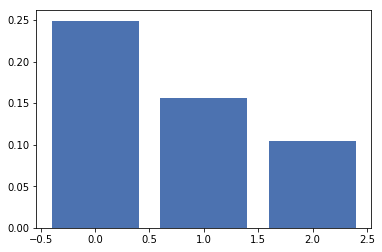

In [8]:
# prepare the features x

from sklearn.preprocessing import StandardScaler

# construct a list with audio features column names
audio_features = artists_to_analyze.columns.drop(['artist_name'])

# separate the features of the rest of columns
x_pca = artists_to_analyze.loc[:, audio_features].values

# scale
x_pca = StandardScaler().fit_transform(x_pca)

# Apply PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# get principal components 
principal_components = pca.fit_transform(x_pca)

# print explained variance by each ratio
print('Explained variance: ', pca.explained_variance_ratio_)
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

# convert to datartists_to_analyzeaframe
pca_df = pd.DataFrame(principal_components, columns = ['pc1', 'pc2', 'pc3'])

# merge priartists_to_plotncipal components into main artists_features dataframe
artists_to_analyze = pd.concat([artists_to_analyze, pca_df], axis=1)

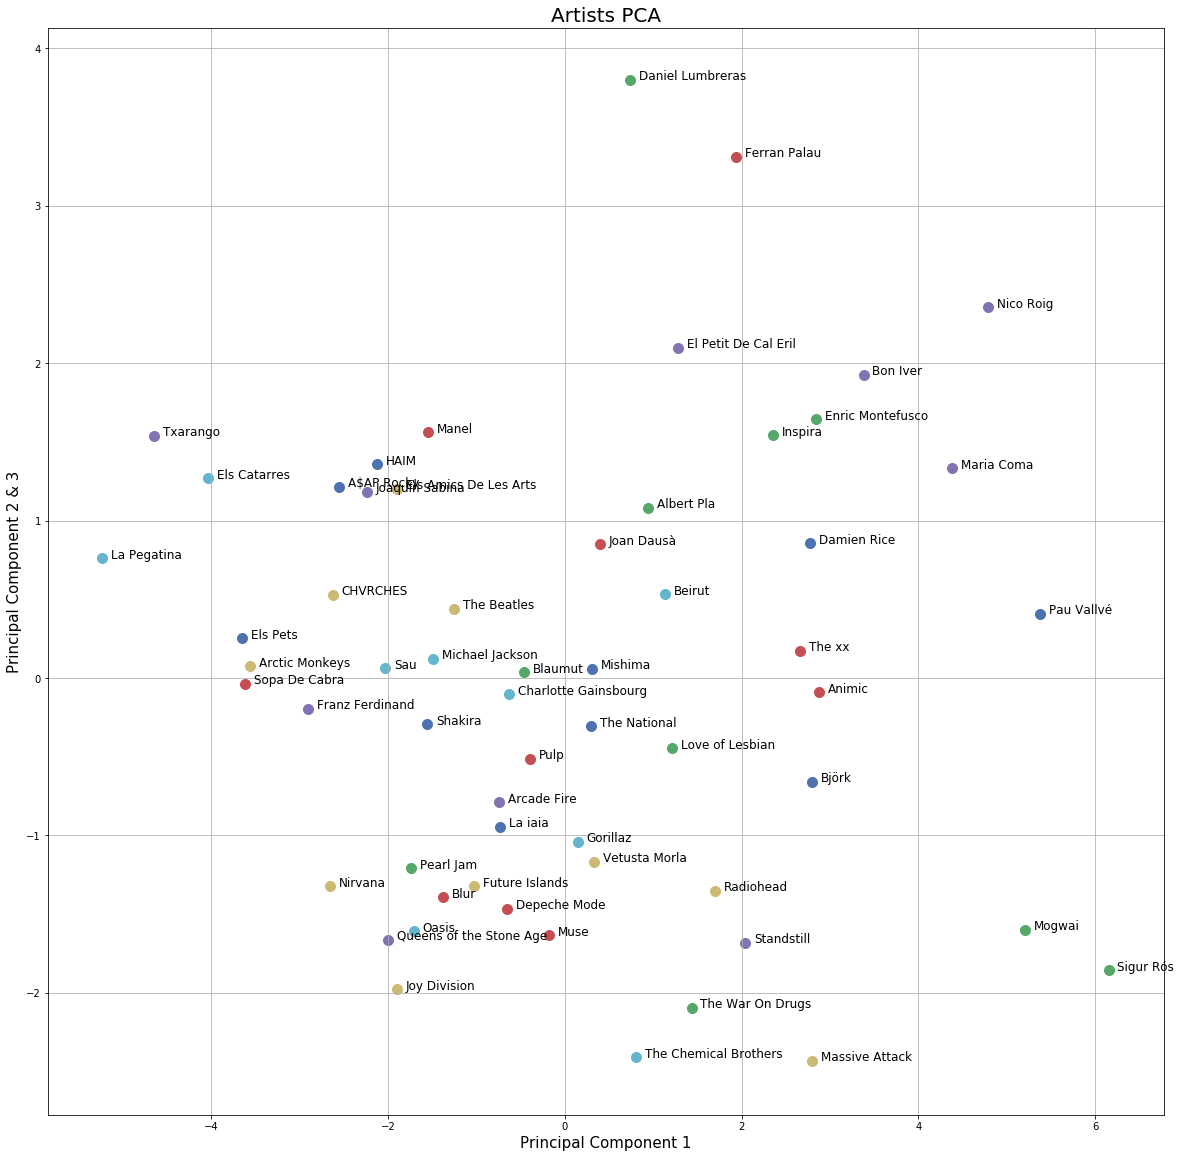

In [10]:
# scatter plot of the artists

%matplotlib inline

artists_to_plot = artists_to_analyze['artist_name']
#artists_to_plot = ['Albert Pla', 'Animic', 'Blaumut', 'El Petit De Cal Eril', 'Els Amics De Les Arts', 'Els Catarres', 'Els Pets', 'Enric Montefusco', 'Ferran Palau', 
#                 'Inspira', 'Joan Dausà', 'La Pegatina', 'La iaia', 'Love of Lesbian', 'Manel', 'Maria Coma', 'Mishima', 'Nico Roig', 'Pau Vallvé', 
#                 'Sau', 'Sopa De Cabra', 'Standstill', 'Txarango']

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2 & 3', fontsize = 15)
ax.set_title('Artists PCA', fontsize = 20)

for a in artists_to_plot:
    index = artists_to_analyze['artist_name'] == a
    
    x = artists_to_analyze.loc[index, 'pc1']
    
    #y = artists_to_analyze.loc[index, 'pc2']
    
    # merge pc2 and pc3 weighted by how many variance they explain
    y = (artists_to_analyze.loc[index, 'pc2']*pca.explained_variance_ratio_[1] + 
        artists_to_analyze.loc[index, 'pc3']*pca.explained_variance_ratio_[2]) / (pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])
        
    ax.scatter(x, y, s = 100)

    ax.text(x + 0.1, y, a, fontsize=12)
    
#ax.legend(artists_features['artist_name'])
ax.grid()

<IPython.core.display.Javascript object>


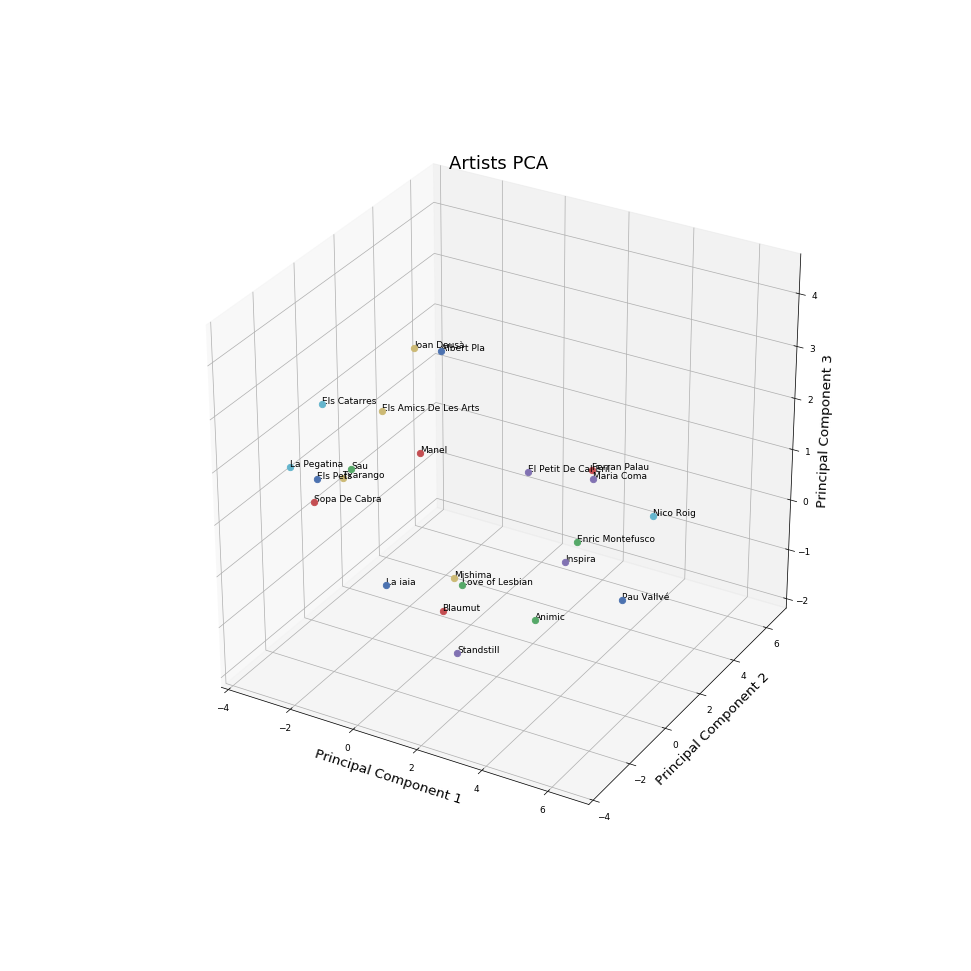

In [123]:
# 3D scatter plot of the artists

%matplotlib nbagg

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('Artists PCA', fontsize = 20)

ax.set_xlim(-4,7)
ax.set_ylim(-4,7)

for a in artists_to_plot:
    
    index = artists_to_analyze['artist_name'] == a

    ax.scatter(artists_to_analyze.loc[index, 'pc1'],
               artists_to_analyze.loc[index, 'pc2'],
               artists_to_analyze.loc[index, 'pc3'],
               zdir='z', 
               s=50
              )

    ax.text(artists_to_analyze.loc[index, 'pc1'].values[0],
            artists_to_analyze.loc[index, 'pc2'].values[0],
            artists_to_analyze.loc[index, 'pc3'].values[0],
            a,
            zdir=None
           )
    
#ax.legend(artists_features['artist_name'])
#ax.grid()

## Band Similarity Matrix

In [21]:
# construct the band similarity matrix using the PCA components
band_similarity_pca = {}
for index1, artist1 in artists_to_analyze.iterrows():
    band_similarity_pca[artist1['artist_name']] = []
    
    for index2, artist2 in artists_to_analyze.iterrows():
                
        euclidean_dist = np.linalg.norm(np.array(artist1[['pc1','pc2','pc3']]) - np.array(artist2[['pc1','pc2','pc3']]))
                
        if euclidean_dist != 0 :
            band_similarity_pca[artist1['artist_name']].append({
                'artist' : artist2['artist_name'],
                'euclidean_dist' : euclidean_dist
            })

In [22]:
# construct the band similarity matrix using the audio features
band_similarity_af = {}
for index1, artist1 in artists_to_analyze.iterrows():
    band_similarity_af[artist1['artist_name']] = []
    
    for index2, artist2 in artists_to_analyze.iterrows():
                
        euclidean_dist = np.linalg.norm(np.array(artist1.drop(['index','artist_name','pc1','pc2','pc3'])) - np.array(artist2.drop(['index','artist_name','pc1','pc2','pc3'])))
                
        if euclidean_dist != 0 :
            band_similarity_af[artist1['artist_name']].append({
                'artist' : artist2['artist_name'],
                'euclidean_dist' : euclidean_dist
            })

In [37]:
artist_name = 'Shakira'

# top similar artists to an artist using PCA components
pprint(sorted(band_similarity_pca[artist_name], key = lambda k: k["euclidean_dist"])[:10])

print()

# top similar artists to an artist using all audio features
pprint(sorted(band_similarity_af[artist_name], key = lambda k: k["euclidean_dist"])[:10])

[{'artist': 'Sau', 'euclidean_dist': 0.7045776988155984},
 {'artist': 'Michael Jackson', 'euclidean_dist': 1.0472424904055606},
 {'artist': 'The Beatles', 'euclidean_dist': 1.4038195999272498},
 {'artist': 'Blur', 'euclidean_dist': 1.6548515586095687},
 {'artist': 'La iaia', 'euclidean_dist': 1.6831706394499968},
 {'artist': 'Gorillaz', 'euclidean_dist': 1.99385148148119},
 {'artist': 'Pulp', 'euclidean_dist': 2.0179027149227102},
 {'artist': 'Els Amics De Les Arts', 'euclidean_dist': 2.1042666682669307},
 {'artist': 'Depeche Mode', 'euclidean_dist': 2.1942038689398378},
 {'artist': 'Arcade Fire', 'euclidean_dist': 2.316633462991945}]

[{'artist': 'Enric Montefusco', 'euclidean_dist': 5400.7221100865745},
 {'artist': 'Bon Iver', 'euclidean_dist': 6525.402182077907},
 {'artist': 'Franz Ferdinand', 'euclidean_dist': 6730.107451661032},
 {'artist': 'Inspira', 'euclidean_dist': 7078.81425952282},
 {'artist': 'Nirvana', 'euclidean_dist': 10168.656165639723},
 {'artist': 'La iaia', 'euclidea